In [2]:
import deepchem as dc

Skipped loading some Pytorch utilities, missing a dependency. No module named 'torch'


This module requires PyTorch to be installed.


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


# Load CSV into DataFrame

In [3]:
import pandas as pd
df = pd.read_csv("target_CHEMBL240-1.IC50_ready.csv.gz", compression="gzip")

# Extract Fingerprints and Target

In [4]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

# Generate Fingerprints
def generate_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    from rdkit import Chem
    from rdkit.Chem import AllChem
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, n_bits)

df["Morgan"] = df['Standardized_SMILES'].parallel_apply(generate_morgan_fingerprint)

def generate_avalon_fingerprint(smiles, n_bits=2048):
    from rdkit import Chem
    from rdkit.Avalon import pyAvalonTools
    mol = Chem.MolFromSmiles(smiles)
    return pyAvalonTools.GetAvalonFP(mol, nBits=n_bits)

df["Avalon"] = df['Standardized_SMILES'].parallel_apply(generate_avalon_fingerprint)

def generate_maccs_fingerprint(smiles):
    from rdkit import Chem
    from rdkit.Chem import MACCSkeys
    mol = Chem.MolFromSmiles(smiles)
    return MACCSkeys.GenMACCSKeys(mol)

df["MACCS"] = df['Standardized_SMILES'].parallel_apply(generate_maccs_fingerprint)

def generate_tto_fingerprint(smiles, n_bits=2048):
    from rdkit import Chem
    from rdkit.Chem import rdMolDescriptors
    mol = Chem.MolFromSmiles(smiles)
    return rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=n_bits)

df["TTO"] = df['Standardized_SMILES'].parallel_apply(generate_tto_fingerprint)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [5]:
# Convert from regression to classification problem
df["target"] = (df['pchembl_value'] >= 7) * 1

# Upper bound (duplicates)

In [6]:
# Find duplicates
smiles_duplicates = df[df["Standardized_SMILES"].duplicated(keep=False)==True]
print("Smiles", len(smiles_duplicates))

def array_to_str(arr):
    return ''.join([str(j) for j in arr])

morgan_string = df["Morgan"].apply(array_to_str)
avalon_string = df["Avalon"].apply(array_to_str)
maccs_string = df["MACCS"].apply(array_to_str)
tto_string = df["TTO"].apply(array_to_str)

morgan_duplicates = df[morgan_string.duplicated(keep=False)==True]
print("Morgan", len(morgan_duplicates))

avalon_duplicates = df[avalon_string.duplicated(keep=False)==True]
print("Avalon", len(avalon_duplicates))

maccs_duplicates = df[maccs_string.duplicated(keep=False)==True]
print("MACCS", len(maccs_duplicates))

tto_duplicates = df[tto_string.duplicated(keep=False)==True]
print("TTO", len(tto_duplicates))

Smiles 348
Morgan 348
Avalon 350
MACCS 788
TTO 348


In [7]:
import numpy as np
# Get mean of each group of duplicates
morgan_duplicates_str = morgan_duplicates["Morgan"].apply(array_to_str)
avalon_duplicates_str = avalon_duplicates["Avalon"].apply(array_to_str)
maccs_duplicates_str = maccs_duplicates["MACCS"].apply(array_to_str)
tto_duplicates_str = tto_duplicates["TTO"].apply(array_to_str)

morgan_means = morgan_duplicates.groupby(morgan_duplicates_str)["target"].mean()
avalon_means = avalon_duplicates.groupby(avalon_duplicates_str)["target"].mean()
maccs_means = maccs_duplicates.groupby(maccs_duplicates_str)["target"].mean()
tto_means = tto_duplicates.groupby(tto_duplicates_str)["target"].mean()

# Replace each duplicate by mean of duplicate group
morgan_predictions_upper = np.array(morgan_means[morgan_duplicates_str])
avalon_predictions_upper = np.array(avalon_means[avalon_duplicates_str])
maccs_predictions_upper = np.array(maccs_means[maccs_duplicates_str])
tto_predictions_upper = np.array(tto_means[tto_duplicates_str])

# Get targets each prediction corresponds to
morgan_targets_upper = morgan_duplicates["target"]
avalon_targets_upper = avalon_duplicates["target"]
maccs_targets_upper = maccs_duplicates["target"]
tto_targets_upper = tto_duplicates["target"]

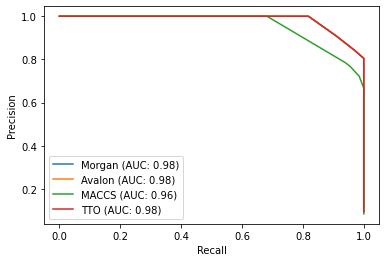

In [8]:
# Get precision recall curves
from sklearn import metrics
morgan_upper_precision, morgan_upper_recall, _ = metrics.precision_recall_curve(
    morgan_targets_upper, morgan_predictions_upper)
morgan_upper_rp_auc = metrics.auc(morgan_upper_recall, morgan_upper_precision)

avalon_upper_precision, avalon_upper_recall, _ = metrics.precision_recall_curve(
    avalon_targets_upper, avalon_predictions_upper)
avalon_upper_rp_auc = metrics.auc(avalon_upper_recall, avalon_upper_precision)

maccs_upper_precision, maccs_upper_recall, _ = metrics.precision_recall_curve(
    maccs_targets_upper, maccs_predictions_upper)
maccs_upper_rp_auc = metrics.auc(maccs_upper_recall, maccs_upper_precision)

tto_upper_precision, tto_upper_recall, _ = metrics.precision_recall_curve(
    tto_targets_upper, tto_predictions_upper)
tto_upper_rp_auc = metrics.auc(tto_upper_recall, tto_upper_precision)

import matplotlib.pyplot as plt

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(morgan_upper_recall, morgan_upper_precision,
         label="Morgan (AUC: " + str(round(morgan_upper_rp_auc*100)/100) + ")")
plt.plot(avalon_upper_recall, avalon_upper_precision,
         label="Avalon (AUC: " + str(round(avalon_upper_rp_auc*100)/100) + ")")
plt.plot(maccs_upper_recall, maccs_upper_precision,
         label="MACCS (AUC: " + str(round(maccs_upper_rp_auc*100)/100) + ")")
plt.plot(tto_upper_recall, tto_upper_precision,
         label="TTO (AUC: " + str(round(tto_upper_rp_auc*100)/100) + ")")
plt.legend()
plt.show()

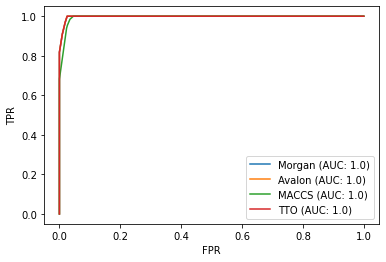

In [9]:
# Get ROC curves
from sklearn import metrics
morgan_upper_fpr, morgan_upper_tpr, _ = metrics.roc_curve(
    morgan_targets_upper, morgan_predictions_upper)
morgan_upper_roc_auc = metrics.auc(morgan_upper_fpr, morgan_upper_tpr)

avalon_upper_fpr, avalon_upper_tpr, _ = metrics.roc_curve(
    avalon_targets_upper, avalon_predictions_upper)
avalon_upper_roc_auc = metrics.auc(avalon_upper_fpr, avalon_upper_tpr)

maccs_upper_fpr, maccs_upper_tpr, _ = metrics.roc_curve(
    maccs_targets_upper, maccs_predictions_upper)
maccs_upper_roc_auc = metrics.auc(maccs_upper_fpr, maccs_upper_tpr)

tto_upper_fpr, tto_upper_tpr, _ = metrics.roc_curve(
    tto_targets_upper, tto_predictions_upper)
tto_upper_roc_auc = metrics.auc(tto_upper_fpr, tto_upper_tpr)

import matplotlib.pyplot as plt

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(morgan_upper_fpr, morgan_upper_tpr,
         label="Morgan (AUC: " + str(round(morgan_upper_roc_auc*100)/100) + ")")
plt.plot(avalon_upper_fpr, avalon_upper_tpr,
         label="Avalon (AUC: " + str(round(avalon_upper_roc_auc*100)/100) + ")")
plt.plot(maccs_upper_fpr, maccs_upper_tpr,
         label="MACCS (AUC: " + str(round(maccs_upper_roc_auc*100)/100) + ")")
plt.plot(tto_upper_fpr, tto_upper_tpr,
         label="TTO (AUC: " + str(round(tto_upper_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

# Remove Duplicate InchiKeys

In [10]:
from rdkit.Chem.inchi import InchiToInchiKey
df["InChIKey14"] = df["Standardized_InChI"].parallel_apply(InchiToInchiKey).apply(lambda x: x[:14])
df = df.drop_duplicates("InChIKey14").reset_index()

# Split Train Test

In [11]:
# Number each row to remember which is which
df["index"] = df.index

# Convert SMILES and index to DeemChem Dataset format
dataset = dc.data.DiskDataset.from_dataframe(df, X="index", ids="Standardized_SMILES")

# Split DeepChem dataset by Scaffolding
train, test = dc.splits.ScaffoldSplitter().train_test_split(dataset, train_size=0.8)

# Obtain row numbers for each set
train_row_numbers = train.X[:,0]
test_row_numbers = test.X[:,0]

# Extract train set and test set rows
train_df = df.iloc[train_row_numbers]
test_df = df.iloc[test_row_numbers]

In [12]:
# Compute Tanimoto distances
def calculate_tanimoto_matrix(fp, other_fps):
    from rdkit import DataStructs
    import numpy as np
    return np.array([(1.0 - DataStructs.TanimotoSimilarity(fp, other_fp)
                     ) for other_fp in other_fps])

train_df["Tanimoto Morgan"] = train_df["Morgan"].parallel_apply(calculate_tanimoto_matrix,
                                                    args=(list(train_df["Morgan"]),))

train_df["Tanimoto Avalon"] = train_df["Avalon"].parallel_apply(calculate_tanimoto_matrix,
                                                    args=(list(train_df["Avalon"]),))

train_df["Tanimoto MACCS"] = train_df["MACCS"].parallel_apply(calculate_tanimoto_matrix,
                                                    args=(list(train_df["MACCS"]),))

train_df["Tanimoto TTO"] = train_df["TTO"].parallel_apply(calculate_tanimoto_matrix,
                                                    args=(list(train_df["TTO"]),))

test_df["Tanimoto Morgan"] = test_df["Morgan"].parallel_apply(calculate_tanimoto_matrix,
                                                    args=(list(train_df["Morgan"]),))

test_df["Tanimoto Avalon"] = test_df["Avalon"].parallel_apply(calculate_tanimoto_matrix,
                                                    args=(list(train_df["Avalon"]),))

test_df["Tanimoto MACCS"] = test_df["MACCS"].parallel_apply(calculate_tanimoto_matrix,
                                                    args=(list(train_df["MACCS"]),))

test_df["Tanimoto TTO"] = test_df["TTO"].parallel_apply(calculate_tanimoto_matrix,
                                                    args=(list(train_df["TTO"]),))
# Convert RDKit Fingerprints to NumPy Arrays

def fingerprint_to_array(fp):
    """Convert RDKit fingerprint to an array."""
    from rdkit import DataStructs
    import numpy as np
    arr = np.zeros((1,), dtype=np.int32)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

train_df["Morgan"] = train_df["Morgan"].parallel_apply(fingerprint_to_array)
train_df["Avalon"] = train_df["Avalon"].parallel_apply(fingerprint_to_array)
train_df["MACCS"] = train_df["MACCS"].parallel_apply(fingerprint_to_array)
train_df["TTO"] = train_df["TTO"].parallel_apply(fingerprint_to_array)

test_df["Morgan"] = test_df["Morgan"].parallel_apply(fingerprint_to_array)
test_df["Avalon"] = test_df["Avalon"].parallel_apply(fingerprint_to_array)
test_df["MACCS"] = test_df["MACCS"].parallel_apply(fingerprint_to_array)
test_df["TTO"] = test_df["TTO"].parallel_apply(fingerprint_to_array)

C:\Users\KA37B~1.KYR\AppData\Local\Temp/ipykernel_12900/3765813862.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Tanimoto Morgan"] = train_df["Morgan"].parallel_apply(calculate_tanimoto_matrix,
C:\Users\KA37B~1.KYR\AppData\Local\Temp/ipykernel_12900/3765813862.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Tanimoto Avalon"] = train_df["Avalon"].parallel_apply(calculate_tanimoto_matrix,
C:\Users\KA37B~1.KYR\AppData\Local\Temp/ipykernel_12900/3765813862.py:14: SettingWithCopyWa

# Lower bound (tanimoto nearest neighbour)

In [13]:
# Get Tanimoto distance matrices

X_train_tanimoto_morgan = np.array(list(train_df["Tanimoto Morgan"]))
X_train_tanimoto_avalon = np.array(list(train_df["Tanimoto Avalon"]))
X_train_tanimoto_maccs = np.array(list(train_df["Tanimoto MACCS"]))
X_train_tanimoto_tto = np.array(list(train_df["Tanimoto TTO"]))

X_test_tanimoto_morgan = np.array(list(test_df["Tanimoto Morgan"]))
X_test_tanimoto_avalon = np.array(list(test_df["Tanimoto Avalon"]))
X_test_tanimoto_maccs = np.array(list(test_df["Tanimoto MACCS"]))
X_test_tanimoto_tto = np.array(list(test_df["Tanimoto TTO"]))

y_train = train_df["target"]
y_test = test_df["target"]

In [14]:
from sklearn.neighbors import KNeighborsClassifier
# Make Nearest Neighbours predictions
def nearest_neighbours(X_train, y_train, X_test):
    nearest = KNeighborsClassifier(n_neighbors = 3, metric="precomputed")
    nearest.fit(X_train, y_train)
    return nearest.predict_proba(X_test)[:,1]

predictions_tanimoto_morgan = nearest_neighbours(
    X_train_tanimoto_morgan, y_train, X_test_tanimoto_morgan)

predictions_tanimoto_avalon = nearest_neighbours(
    X_train_tanimoto_avalon, y_train, X_test_tanimoto_avalon)

predictions_tanimoto_maccs = nearest_neighbours(
    X_train_tanimoto_maccs, y_train, X_test_tanimoto_maccs)

predictions_tanimoto_tto = nearest_neighbours(
    X_train_tanimoto_tto, y_train, X_test_tanimoto_tto)

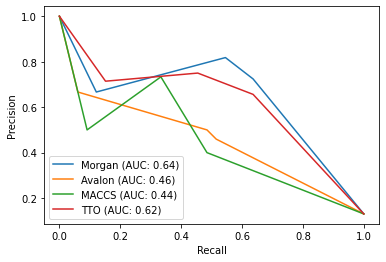

In [15]:
# Get precision recall curves

morgan_lower_precision, morgan_lower_recall, _ = metrics.precision_recall_curve(
    y_test, predictions_tanimoto_morgan)
morgan_lower_rp_auc = metrics.auc(morgan_lower_recall, morgan_lower_precision)

avalon_lower_precision, avalon_lower_recall, _ = metrics.precision_recall_curve(
    y_test, predictions_tanimoto_avalon)
avalon_lower_rp_auc = metrics.auc(avalon_lower_recall, avalon_lower_precision)

maccs_lower_precision, maccs_lower_recall, _ = metrics.precision_recall_curve(
    y_test, predictions_tanimoto_maccs)
maccs_lower_rp_auc = metrics.auc(maccs_lower_recall, maccs_lower_precision)

tto_lower_precision, tto_lower_recall, _ = metrics.precision_recall_curve(
    y_test, predictions_tanimoto_tto)
tto_lower_rp_auc = metrics.auc(tto_lower_recall, tto_lower_precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(morgan_lower_recall, morgan_lower_precision,
         label="Morgan (AUC: " + str(round(morgan_lower_rp_auc*100)/100) + ")")
plt.plot(avalon_lower_recall, avalon_lower_precision,
         label="Avalon (AUC: " + str(round(avalon_lower_rp_auc*100)/100) + ")")
plt.plot(maccs_lower_recall, maccs_lower_precision,
         label="MACCS (AUC: " + str(round(maccs_lower_rp_auc*100)/100) + ")")
plt.plot(tto_lower_recall, tto_lower_precision,
         label="TTO (AUC: " + str(round(tto_lower_rp_auc*100)/100) + ")")
plt.legend()
plt.show()

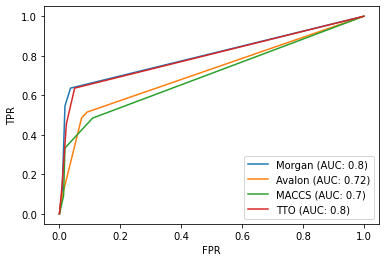

In [16]:
# Get ROC curves
morgan_lower_fpr, morgan_lower_tpr, _ = metrics.roc_curve(
    y_test, predictions_tanimoto_morgan)
morgan_lower_roc_auc = metrics.auc(morgan_lower_fpr, morgan_lower_tpr)

avalon_lower_fpr, avalon_lower_tpr, _ = metrics.roc_curve(
    y_test, predictions_tanimoto_avalon)
avalon_lower_roc_auc = metrics.auc(avalon_lower_fpr, avalon_lower_tpr)

maccs_lower_fpr, maccs_lower_tpr, _ = metrics.roc_curve(
    y_test, predictions_tanimoto_maccs)
maccs_lower_roc_auc = metrics.auc(maccs_lower_fpr, maccs_lower_tpr)

tto_lower_fpr, tto_lower_tpr, _ = metrics.roc_curve(
    y_test, predictions_tanimoto_tto)
tto_lower_roc_auc = metrics.auc(tto_lower_fpr, tto_lower_tpr)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(morgan_lower_fpr, morgan_lower_tpr,
         label="Morgan (AUC: " + str(round(morgan_lower_roc_auc*100)/100) + ")")
plt.plot(avalon_lower_fpr, avalon_lower_tpr,
         label="Avalon (AUC: " + str(round(avalon_lower_roc_auc*100)/100) + ")")
plt.plot(maccs_lower_fpr, maccs_lower_tpr,
         label="MACCS (AUC: " + str(round(maccs_lower_roc_auc*100)/100) + ")")
plt.plot(tto_lower_fpr, tto_lower_tpr,
         label="TTO (AUC: " + str(round(tto_lower_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

# Lower bound - random

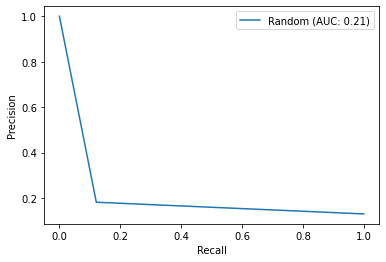

In [17]:
random_predict = (np.random.random(len(y_test)) < y_train.mean())*1

# Get precision-recall curves - random baseline

random_precision, random_recall, _ = metrics.precision_recall_curve(y_test, random_predict)
random_rp_auc = metrics.auc(random_recall, random_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(random_recall, random_precision,
         label="Random (AUC: " + str(round(random_rp_auc*100)/100) + ")")
plt.legend()
plt.show()

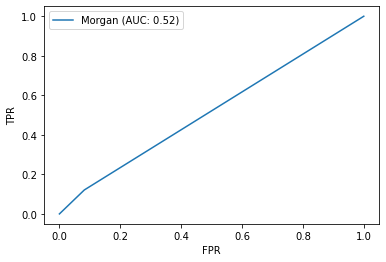

In [18]:
# Get ROC curves
random_fpr, random_tpr, _ = metrics.roc_curve(y_test, random_predict)
random_roc_auc = metrics.auc(random_fpr, random_tpr)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(random_fpr, random_tpr,
         label="Morgan (AUC: " + str(round(random_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

# Random Forest

In [19]:
X_train_morgan = np.array(list(train_df["Morgan"]))
X_train_avalon = np.array(list(train_df["Avalon"]))
X_train_maccs = np.array(list(train_df["MACCS"]))
X_train_tto = np.array(list(train_df["TTO"]))

X_test_morgan = np.array(list(test_df["Morgan"]))
X_test_avalon = np.array(list(test_df["Avalon"]))
X_test_maccs = np.array(list(test_df["MACCS"]))
X_test_tto = np.array(list(test_df["TTO"]))

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def rf_model(X_train, y_train, X_test):
    param_grid = { 
        "bootstrap": [True],
        'max_depth' : [80, 90, 100],
        'max_features': [2, 3],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 200, 300],
    }
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    sf = StratifiedKFold(n_splits=4)
    model = GridSearchCV(rf, param_grid, cv=sf)
    model.fit(X_train, y_train)
    print(model.best_params_)
    return model.predict_proba(X_test)[:,1]

rf_predictions_morgan = rf_model(X_train_morgan, y_train, X_test_morgan)
rf_predictions_avalon = rf_model(X_train_avalon, y_train, X_test_avalon)
rf_predictions_maccs = rf_model(X_train_maccs, y_train, X_test_maccs)
rf_predictions_tto = rf_model(X_train_tto, y_train, X_test_tto)

C:\Users\k.kyriakop\Anaconda3\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


C:\Users\k.kyriakop\Anaconda3\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}
{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


C:\Users\k.kyriakop\Anaconda3\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


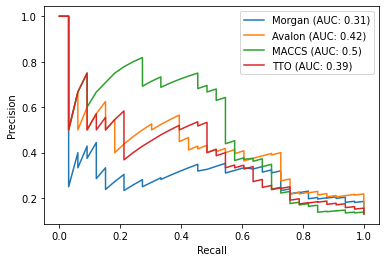

In [48]:
# Get precision recall curves

morgan_precision, morgan_recall, _ = metrics.precision_recall_curve(
    y_test, rf_predictions_morgan)
morgan_rp_auc = metrics.auc(morgan_recall, morgan_precision)

avalon_precision, avalon_recall, _ = metrics.precision_recall_curve(
    y_test, rf_predictions_avalon)
avalon_rp_auc = metrics.auc(avalon_recall, avalon_precision)

maccs_precision, maccs_recall, _ = metrics.precision_recall_curve(
    y_test, rf_predictions_maccs)
maccs_rp_auc = metrics.auc(maccs_recall, maccs_precision)

tto_precision, tto_recall, _ = metrics.precision_recall_curve(
    y_test, rf_predictions_tto)
tto_rp_auc = metrics.auc(tto_recall, tto_precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(morgan_recall, morgan_precision,
         label="Morgan (AUC: " + str(round(morgan_rp_auc*100)/100) + ")")
plt.plot(avalon_recall, avalon_precision,
         label="Avalon (AUC: " + str(round(avalon_rp_auc*100)/100) + ")")
plt.plot(maccs_recall, maccs_precision,
         label="MACCS (AUC: " + str(round(maccs_rp_auc*100)/100) + ")")
plt.plot(tto_recall, tto_precision,
         label="TTO (AUC: " + str(round(tto_rp_auc*100)/100) + ")")
plt.legend()
plt.show()

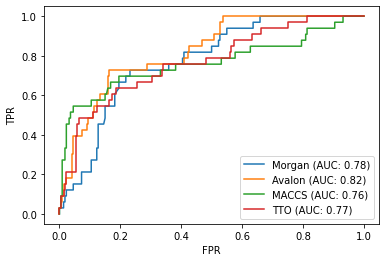

In [49]:
# Get ROC curves
morgan_fpr, morgan_tpr, _ = metrics.roc_curve(y_test, rf_predictions_morgan)
morgan_roc_auc = metrics.auc(morgan_fpr, morgan_tpr)

avalon_fpr, avalon_tpr, _ = metrics.roc_curve(y_test, rf_predictions_avalon)
avalon_roc_auc = metrics.auc(avalon_fpr, avalon_tpr)

maccs_fpr, maccs_tpr, _ = metrics.roc_curve(y_test, rf_predictions_maccs)
maccs_roc_auc = metrics.auc(maccs_fpr, maccs_tpr)

tto_fpr, tto_tpr, _ = metrics.roc_curve(y_test, rf_predictions_tto)
tto_roc_auc = metrics.auc(tto_fpr, tto_tpr)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(morgan_fpr, morgan_tpr,
         label="Morgan (AUC: " + str(round(morgan_roc_auc*100)/100) + ")")
plt.plot(avalon_fpr, avalon_tpr,
         label="Avalon (AUC: " + str(round(avalon_roc_auc*100)/100) + ")")
plt.plot(maccs_fpr, maccs_tpr,
         label="MACCS (AUC: " + str(round(maccs_roc_auc*100)/100) + ")")
plt.plot(tto_fpr, tto_tpr,
         label="TTO (AUC: " + str(round(tto_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

# Plots per fingerprint

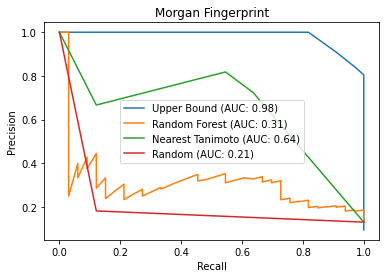

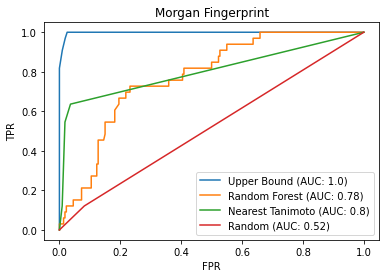

In [53]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Morgan Fingerprint")
plt.plot(morgan_upper_recall, morgan_upper_precision,
         label="Upper Bound (AUC: " + str(round(morgan_upper_rp_auc*100)/100) + ")")
plt.plot(morgan_recall, morgan_precision,
         label="Random Forest (AUC: " + str(round(morgan_rp_auc*100)/100) + ")")
plt.plot(morgan_lower_recall, morgan_lower_precision,
         label="Nearest Tanimoto (AUC: " + str(round(morgan_lower_rp_auc*100)/100) + ")")
plt.plot(random_recall, random_precision,
         label="Random (AUC: " + str(round(random_rp_auc*100)/100) + ")")
plt.legend()
plt.show()
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("Morgan Fingerprint")
plt.plot(morgan_upper_fpr, morgan_upper_tpr,
         label="Upper Bound (AUC: " + str(round(morgan_upper_roc_auc*100)/100) + ")")
plt.plot(morgan_fpr, morgan_tpr,
         label="Random Forest (AUC: " + str(round(morgan_roc_auc*100)/100) + ")")
plt.plot(morgan_lower_fpr, morgan_lower_tpr,
         label="Nearest Tanimoto (AUC: " + str(round(morgan_lower_roc_auc*100)/100) + ")")
plt.plot(random_fpr, random_tpr,
         label="Random (AUC: " + str(round(random_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

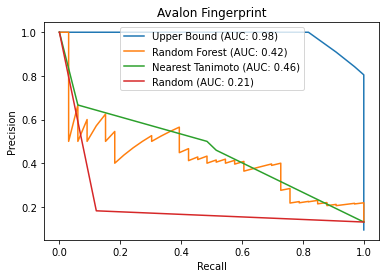

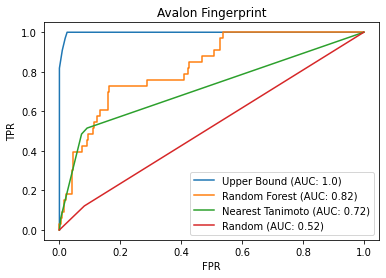

In [57]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Avalon Fingerprint")
plt.plot(avalon_upper_recall, avalon_upper_precision,
         label="Upper Bound (AUC: " + str(round(avalon_upper_rp_auc*100)/100) + ")")
plt.plot(avalon_recall, avalon_precision,
         label="Random Forest (AUC: " + str(round(avalon_rp_auc*100)/100) + ")")
plt.plot(avalon_lower_recall, avalon_lower_precision,
         label="Nearest Tanimoto (AUC: " + str(round(avalon_lower_rp_auc*100)/100) + ")")
plt.plot(random_recall, random_precision,
         label="Random (AUC: " + str(round(random_rp_auc*100)/100) + ")")
plt.legend()
plt.show()
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("Avalon Fingerprint")
plt.plot(avalon_upper_fpr, avalon_upper_tpr,
         label="Upper Bound (AUC: " + str(round(avalon_upper_roc_auc*100)/100) + ")")
plt.plot(avalon_fpr, avalon_tpr,
         label="Random Forest (AUC: " + str(round(avalon_roc_auc*100)/100) + ")")
plt.plot(avalon_lower_fpr, avalon_lower_tpr,
         label="Nearest Tanimoto (AUC: " + str(round(avalon_lower_roc_auc*100)/100) + ")")
plt.plot(random_fpr, random_tpr,
         label="Random (AUC: " + str(round(random_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

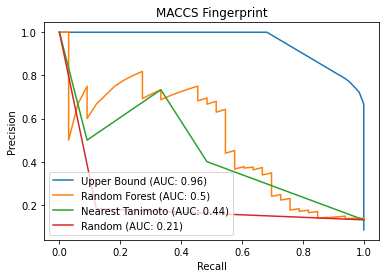

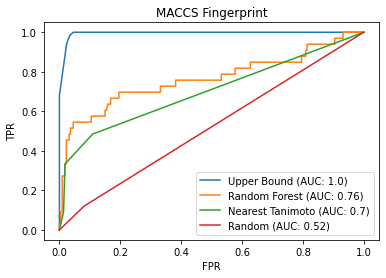

In [55]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("MACCS Fingerprint")
plt.plot(maccs_upper_recall, maccs_upper_precision,
         label="Upper Bound (AUC: " + str(round(maccs_upper_rp_auc*100)/100) + ")")
plt.plot(maccs_recall, maccs_precision,
         label="Random Forest (AUC: " + str(round(maccs_rp_auc*100)/100) + ")")
plt.plot(maccs_lower_recall, maccs_lower_precision,
         label="Nearest Tanimoto (AUC: " + str(round(maccs_lower_rp_auc*100)/100) + ")")
plt.plot(random_recall, random_precision,
         label="Random (AUC: " + str(round(random_rp_auc*100)/100) + ")")
plt.legend()
plt.show()
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("MACCS Fingerprint")
plt.plot(maccs_upper_fpr, maccs_upper_tpr,
         label="Upper Bound (AUC: " + str(round(maccs_upper_roc_auc*100)/100) + ")")
plt.plot(maccs_fpr, maccs_tpr,
         label="Random Forest (AUC: " + str(round(maccs_roc_auc*100)/100) + ")")
plt.plot(maccs_lower_fpr, maccs_lower_tpr,
         label="Nearest Tanimoto (AUC: " + str(round(maccs_lower_roc_auc*100)/100) + ")")
plt.plot(random_fpr, random_tpr,
         label="Random (AUC: " + str(round(random_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

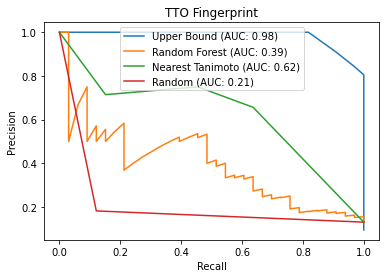

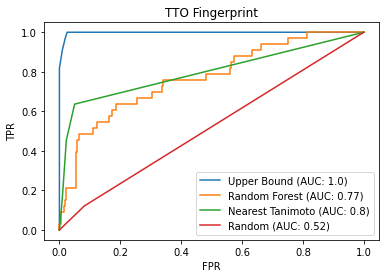

In [56]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("TTO Fingerprint")
plt.plot(tto_upper_recall, tto_upper_precision,
         label="Upper Bound (AUC: " + str(round(tto_upper_rp_auc*100)/100) + ")")
plt.plot(tto_recall, tto_precision,
         label="Random Forest (AUC: " + str(round(tto_rp_auc*100)/100) + ")")
plt.plot(tto_lower_recall, tto_lower_precision,
         label="Nearest Tanimoto (AUC: " + str(round(tto_lower_rp_auc*100)/100) + ")")
plt.plot(random_recall, random_precision,
         label="Random (AUC: " + str(round(random_rp_auc*100)/100) + ")")
plt.legend()
plt.show()
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("TTO Fingerprint")
plt.plot(tto_upper_fpr, tto_upper_tpr,
         label="Upper Bound (AUC: " + str(round(tto_upper_roc_auc*100)/100) + ")")
plt.plot(tto_fpr, tto_tpr,
         label="Random Forest (AUC: " + str(round(tto_roc_auc*100)/100) + ")")
plt.plot(tto_lower_fpr, tto_lower_tpr,
         label="Nearest Tanimoto (AUC: " + str(round(tto_lower_roc_auc*100)/100) + ")")
plt.plot(random_fpr, random_tpr,
         label="Random (AUC: " + str(round(random_roc_auc*100)/100) + ")")
plt.legend()
plt.show()